In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from imblearn.over_sampling import SMOTE

In [2]:
# === 데이터 로드 ===
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


In [3]:
# === ID 컬럼 제거 ===
train = train.drop(columns=['ID'])
test_id = test['ID']
test = test.drop(columns=['ID'])

In [4]:
# === 결측치 처리 (KNN Imputer 적용) ===
columns_fill_knn = ['해당층', '총층', '전용면적', '방수', '욕실수', '총주차대수']
imputer = KNNImputer(n_neighbors=5)
train[columns_fill_knn] = imputer.fit_transform(train[columns_fill_knn])
test[columns_fill_knn] = imputer.transform(test[columns_fill_knn])

In [5]:
# === 레이블 인코딩 (문자 데이터를 숫자로 변환) ===
label_encode_cols = ['중개사무소', '게재일', '제공플랫폼', '방향']
for col in label_encode_cols:
    le = LabelEncoder()
    combined_data = pd.concat([train[col], test[col]], axis=0).astype(str)
    le.fit(combined_data)
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

In [6]:
# === 원-핫 인코딩 (필요한 경우) ===
one_hot_cols = ['매물확인방식', '주차가능여부']
one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
train_encoded = one_hot_encoder.fit_transform(train[one_hot_cols])
test_encoded = one_hot_encoder.transform(test[one_hot_cols])

train = pd.concat([train.drop(columns=one_hot_cols), pd.DataFrame(train_encoded, index=train.index)], axis=1)
test = pd.concat([test.drop(columns=one_hot_cols), pd.DataFrame(test_encoded, index=test.index)], axis=1)

/opt/anaconda3/envs/real_estate_fraud_env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
# === 데이터 분리 ===
X = train.drop(columns=['허위매물여부'])
y = train['허위매물여부']

In [8]:
# 컬럼 이름을 문자열로 변환 (LightGBM 호환성 유지)
X.columns = X.columns.astype(str)

In [9]:
# === SMOTE로 데이터 증강 ===
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)

In [10]:
# 확인
print("✅ 데이터 전처리 완료!")
print("After SMOTE, X_sm shape:", X_sm.shape)
print("After SMOTE, y_sm distribution:\n", pd.Series(y_sm).value_counts())

✅ 데이터 전처리 완료!
After SMOTE, X_sm shape: (4308, 18)
After SMOTE, y_sm distribution:
 0    2154
1    2154
Name: 허위매물여부, dtype: int64


In [11]:
# === Stratified K-Fold 설정 ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
# === LightGBM 하이퍼파라미터 탐색 공간 ===
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "num_leaves": [20, 31, 40],
    "max_depth": [-1, 5, 10],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "n_estimators": [500, 1000]
}

In [13]:
# === 사용자 정의 F1 Score 평가 함수 ===
f1_scorer = make_scorer(f1_score, average="macro")


In [14]:
# === LightGBM 모델 정의 ===
base_model = lgb.LGBMClassifier(objective="binary", random_state=42)

In [15]:
# === GridSearchCV 적용 ===
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=skf,
    verbose=2,
    n_jobs=-1
)

In [16]:
# === 최적 하이퍼파라미터 탐색 ===
grid_search.fit(X_sm, y_sm)


Fitting 5 folds for each of 486 candidates, totalling 2430 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=500, num_leaves=20, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=500, num_leaves=20, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=500, num_leaves=20, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=500, num_leaves=20, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=500, num_leaves=20, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=500, num_leaves=20, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=500, num_leaves=20, subsample=0.8; total time=   0.5s
[CV] END col

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMClassifier(objective='binary', random_state=42),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [-1, 5, 10], 'n_estimators': [500, 1000],
                         'num_leaves': [20, 31, 40],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring=make_scorer(f1_score, average=macro), verbose=2)

In [17]:
# === 최적 파라미터 출력 ===
print("🔍 최적 파라미터:", grid_search.best_params_)
print("🔥 최고 F1 Score:", grid_search.best_score_)

🔍 최적 파라미터: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 1000, 'num_leaves': 20, 'subsample': 0.7}
🔥 최고 F1 Score: 0.9791093398362676


In [18]:
# === 최적 파라미터로 모델 재학습 ===
best_params = grid_search.best_params_
final_model = lgb.LGBMClassifier(**best_params, objective="binary", random_state=42)

oof_preds = np.zeros(len(X_sm))
test_preds = np.zeros(len(test))

for fold, (train_idx, val_idx) in enumerate(skf.split(X_sm, y_sm)):
    print(f"Fold {fold + 1}")
    X_train, X_val = X_sm.iloc[train_idx], X_sm.iloc[val_idx]
    y_train, y_val = y_sm.iloc[train_idx], y_sm.iloc[val_idx]

    final_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric="f1", early_stopping_rounds=50, verbose=100)
    
    oof_preds[val_idx] = final_model.predict_proba(X_val)[:, 1]
    test_preds += final_model.predict_proba(test)[:, 1] / skf.n_splits

Fold 1


/opt/anaconda3/envs/real_estate_fraud_env/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/anaconda3/envs/real_estate_fraud_env/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.0789124
Fold 2


/opt/anaconda3/envs/real_estate_fraud_env/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/anaconda3/envs/real_estate_fraud_env/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.0586181
Fold 3


/opt/anaconda3/envs/real_estate_fraud_env/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/anaconda3/envs/real_estate_fraud_env/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.085994
Fold 4


/opt/anaconda3/envs/real_estate_fraud_env/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/anaconda3/envs/real_estate_fraud_env/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.0645137
Fold 5


/opt/anaconda3/envs/real_estate_fraud_env/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/anaconda3/envs/real_estate_fraud_env/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.053936
[200]	valid_0's binary_logloss: 0.0533446


In [19]:
# === 최적 임곗값 찾기 ===
thresholds = np.linspace(0.1, 0.9, 50)  # 0.1 ~ 0.9 사이 50개 값 테스트
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    preds_binary = (oof_preds > threshold).astype(int)
    f1 = f1_score(y_sm, preds_binary, average="macro")
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"🔍 최적 임곗값: {best_threshold:.3f}, 최적 F1 Score: {best_f1:.5f}")

# === 최적 임곗값으로 변환하여 저장 ===
test_preds_binary = (test_preds > best_threshold).astype(int)

submission = pd.DataFrame({"ID": test_id, "허위매물여부": test_preds_binary})
submission.to_csv("submission_4-2.csv", index=False)

print("✅ 최적 모델 예측 완료! 'submission_4-2.csv' 저장됨.")

🔍 최적 임곗값: 0.524, 최적 F1 Score: 0.97748
✅ 최적 모델 예측 완료! 'submission_4-2.csv' 저장됨.


OOF F1 Score: 0.9774836917119978


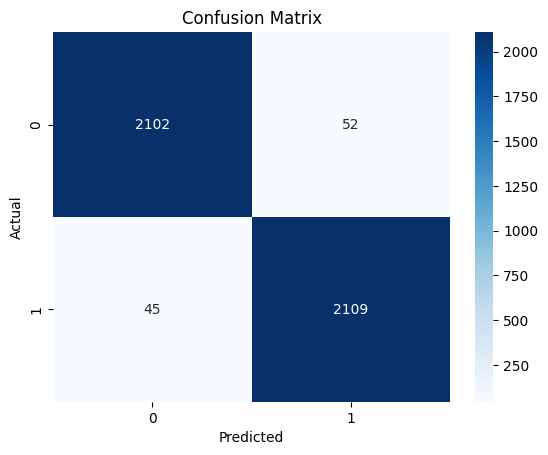

In [24]:
# === 혼동 행렬 시각화 ===
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Convert oof_preds to binary predictions using the best threshold
oof_preds_binary = (oof_preds > best_threshold).astype(int)
print("OOF F1 Score:", f1_score(y_sm, oof_preds_binary, average='macro'))

cm = confusion_matrix(y_sm, oof_preds_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()